In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
def generate_data(params, N=100):
    '''
    generate observations of stochastic process with parameters A, B, C, D
    '''
    epsilon = np.random.randn(N)
    w = np.random.randn(N)
    x = np.zeros(N) # states
    x[0] = 0
    for k in range(1,N):
        x[k] = params['A'] + params['B']*x[k-1] + params['C']*epsilon[k]
    y = x + params['D']*w # observations
    
    return y

def ss_smoother(y, init_params, num_iter=150, x_0=0, R_0=0.1):
    '''
    run Shumway Stoffer smoother algorithm with given initial values
    x_0, R_0 - inital guesses for Kalman filter
    '''
    N = len(y)
    A,B,C,D = [np.zeros(num_iter) for _ in range(4)]
    A[0],B[0],C[0],D[0] = init_params['A'], init_params['B'], init_params['C'], init_params['D']
    
    x_N, R_N = [x_0], [R_0] # initial guesses for Kalman filter
    
    # run algorithm for num_iter iterations
    for i in range(1,num_iter):
        
        # run Kalman filter
        x_pred = np.zeros(N)
        R_pred = np.zeros(N)
        x0 = x_N[0]
        R0 = R_N[0]
        for k in range(0,N):
            # predict
            if k==0:
                x_hat = A[i-1] + B[i-1] * x0
                R_hat = B[i-1]**2 * R0 + C[i-1]**2
            else:
                x_hat = A[i-1] + B[i-1] * x_pred[k-1]
                R_hat = B[i-1]**2 * R_pred[k-1] + C[i-1]**2
            # update
            K = R_hat / (R_hat + D[i-1]**2)
            x_pred[k] = x_hat + K * (y[k] - x_hat)
            R_pred[k] = D[i-1]**2 * K

        # run Shumway-Stoffer backward recursion
        x_N = np.zeros(N)
        R_N = np.zeros(N)
        J = np.zeros(N)
        x_N[-1] = x_pred[-1]
        R_N[-1] = R_pred[-1]

        for k in range(N-2,-1,-1):
            J[k] = B[i-1] * R_pred[k] / ((B[i-1])**2 * R_pred[k] + (C[i-1])**2)
            x_N[k] = x_pred[k] + J[k] * (x_N[k+1] - (A[i-1] + B[i-1] * x_pred[k]))
            R_N[k] = R_pred[k] + J[k]**2 * (R_N[k+1] - ((B[i-1])**2 * R_pred[k] + (C[i-1])**2))    

        # compute alpha
        alpha = np.sum(R_N[:-1] + (x_N**2)[:-1])

        # beta
        sigma_kN = np.zeros(N)
        sigma_kN[-1] = B[i-1] * (1 - K) * R_pred[-1] # i'm not sure about the last term, but it seems that it works
        for k in range(N-2,-1,-1):
            sigma_kN[k] = J[k] * R_pred[k+1] + J[k+1]*J[k] * (sigma_kN[k+1] - B[i-1] * R_pred[k+1])
        beta = np.sum(sigma_kN[:-1] + x_N[1:] * x_N[:-1])

        # gamma, delta
        gamma = np.sum(x_N[1:])
        delta = gamma - x_N[-1] + x_N[0]

        # update parameters
        A[i] = (alpha * gamma - delta*beta) / (N*alpha - delta**2)
        B[i] = (N*beta - gamma*delta) / (N*alpha - delta**2)
        C[i] = np.sqrt(1/(N-1) * np.sum(R_N[1:] + x_N[1:]**2 + A[i]**2 + B[i]**2 * R_N[:-1]
                                    + B[i]**2 * x_N[:-1]**2 - 2*A[i]*x_N[1:] + 2*A[i]*B[i]*x_N[:-1]
                                    - 2*B[i]*sigma_kN[:-1] - 2*B[i]*x_N[1:]*x_N[:-1]))
        D[i] = np.sqrt(1/N * np.sum(y**2 - 2*y*x_N + R_N + x_N**2))
        
    return {'A':A, 'B':B, 'C':C, 'D':D}

def plot_params(true_params, est_params):
    '''
    plot convergence for each parameter
    '''
    fig, axs = plt.subplots(2, 2, figsize=(18,8))
    fig.suptitle('EM algorithm covergence')
    for n,k in zip(np.arange(4), true_params.keys()):
        axs.flatten()[n].plot(np.arange(len(est_params[k])), est_params[k], label=f'Estimate of {k}')
        axs.flatten()[n].hlines(true_params[k], 0, len(est_params[k]), linestyle='dotted', 
                              color='r', label=f'True {k}')
        axs.flatten()[n].legend()

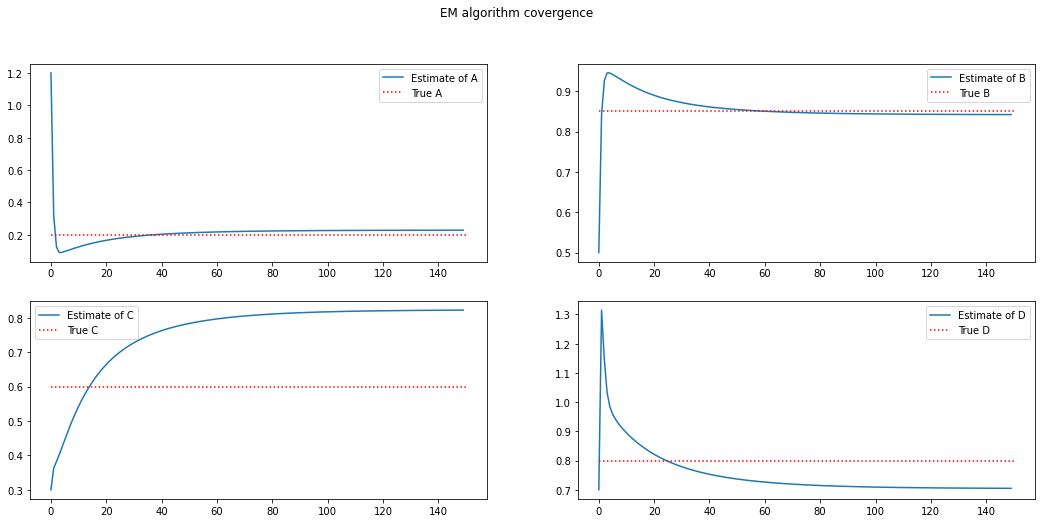

In [3]:
true_params = {'A':0.2, 'B':0.85, 'C':0.6, 'D':0.8}
init_params = {'A':1.2, 'B':0.5, 'C':0.3, 'D':0.7}
np.random.seed(888)
y = generate_data(true_params, N=100)
est_params = ss_smoother(y, init_params, num_iter=150)
plot_params(true_params, est_params)

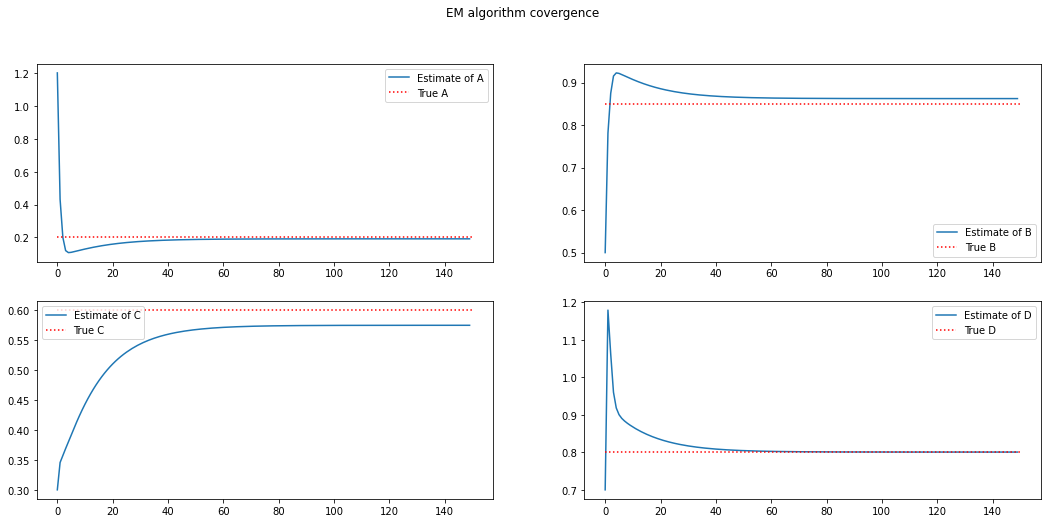

In [4]:
true_params = {'A':0.2, 'B':0.85, 'C':0.6, 'D':0.8}
init_params = {'A':1.2, 'B':0.5, 'C':0.3, 'D':0.7}
np.random.seed(888)
y = generate_data(true_params, N=1000)
est_params = ss_smoother(y, init_params, num_iter=150)
plot_params(true_params, est_params)

# Real data

In [5]:
data = pd.read_csv('biotech_av_v2.csv', index_col=0, parse_dates=True)
data.dropna(axis=1, inplace=True)
returns = data.pct_change().dropna()
cumret = (returns + 1).cumprod()
cumret_norm = cumret / cumret.iloc[0]

In [6]:
def parse_pair(pair):
    '''
    return s1,s2 from string s1-s2
    '''
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

def kalman_filter(y, params):
    '''
    run Kalman filter on y
    '''
    N = len(y)
    A,B,C,D = params['A'],params['B'],params['C'],params['D']
    # run Kalman filter
    x_pred = np.zeros(N)
    R_pred = np.zeros(N)
    x0 = y[0] # inital guess = first measurement
    R0 = D**2
    for k in range(0,N):
        # predict
        if k==0:
            x_hat = A + B * x0
            R_hat = B**2 * R0 + C**2
        else:
            x_hat = A + B * x_pred[k-1]
            R_hat = B**2 * R_pred[k-1] + C**2
        # update
        K = R_hat / (R_hat + D**2)
        x_pred[k] = x_hat + K * (y[k] - x_hat)
        R_pred[k] = D**2 * K
        
    return x_hat, x_pred[-1] # returns yesterday's prediction and today's estimate

# Estimate spread model parameters

In [15]:
good_pairs_all = {} 
window = 30

for i in range(window,len(cumret_norm.index)):
    print(f'Processing day {i-window}')
    cumret_tmp_prev = cumret_norm.iloc[i-window:i,] # data for parameter estimation
    
    # estimate parameters
    ip = {'A':2, 'B':2, 'C':2, 'D':2} # initial parameters
    tested_pairs = []
    good_pairs = {}

    for s1 in cumret_tmp_prev.columns:
        for s2 in cumret_tmp_prev.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested_pairs) and (f'{s2}-{s1}' not in tested_pairs):
                tested_pairs.append(f'{s1}-{s2}')
                spread = cumret_tmp_prev[s1] - cumret_tmp_prev[s2]
                params = ss_smoother(spread, ip,  num_iter=150, x_0=spread.iloc[0], R_0=ip['D'])
                params = {k:v[-1] for k,v in params.items()}
                if params['B']>0 and params['B']<1:
                    if params['C'] < params['D']:
                        good_pairs[f'{s1}-{s2}'] = params # save pair and parameters
    
    # save pairs and parameters
    pairs_df = pd.DataFrame.from_dict(good_pairs, orient='index')
    date = cumret_tmp_prev.index[-1]
    good_pairs_all[date] = pairs_df

Processing day 0
Processing day 1
Processing day 2
Processing day 3
Processing day 4
Processing day 5
Processing day 6
Processing day 7
Processing day 8
Processing day 9
Processing day 10
Processing day 11
Processing day 12
Processing day 13
Processing day 14
Processing day 15
Processing day 16
Processing day 17
Processing day 18
Processing day 19
Processing day 20
Processing day 21
Processing day 22
Processing day 23
Processing day 24
Processing day 25
Processing day 26
Processing day 27
Processing day 28
Processing day 29
Processing day 30
Processing day 31
Processing day 32
Processing day 33
Processing day 34
Processing day 35
Processing day 36
Processing day 37
Processing day 38
Processing day 39
Processing day 40
Processing day 41
Processing day 42
Processing day 43
Processing day 44
Processing day 45
Processing day 46
Processing day 47
Processing day 48
Processing day 49
Processing day 50
Processing day 51
Processing day 52
Processing day 53
Processing day 54
Processing day 55
Pr

In [56]:
# save results to file
import pickle
f = open('spread_params.pkl', 'wb')
pickle.dump(good_pairs_all, f)
f.close()

# Strategy 1, approach 1

In [7]:
with open('spread_params.pkl', 'rb') as f:
    good_pairs_all = pickle.load(f)

selected_pairs_long = []
selected_pairs_short = []
algo_ret = []
num_days = len(cumret_norm.index)

for i in range(30,num_days):
    cumret_tmp = cumret_norm.iloc[i-30:i]
    ret_tmp = returns.iloc[i-1]
    
    # calculate returns
    daily_returns_long = []
    daily_returns_short = []
    if len(selected_pairs_long)>0:
        for pair in selected_pairs_long:
            s1,s2 = parse_pair(pair)
            daily_returns_long.append(ret_tmp[s1] - ret_tmp[s2])
            selected_pairs_long = []
    if len(selected_pairs_short)>0:
        for pair in selected_pairs_short:
            s1,s2 = parse_pair(pair)
            daily_returns_short.append(-ret_tmp[s1] + ret_tmp[s2])
            selected_pairs_short = []
    
    # equal capital allocations to longs\shorts
    daily_return_total = np.mean(daily_returns_long) + np.mean(daily_returns_short)
    algo_ret.append(daily_return_total)
                        
    date = returns.index[i-1]
    if len(good_pairs_all[date].index)>0:
        # calculate spreads
        pairs_df = good_pairs_all[date]

        for pair in pairs_df.index:
            s1,s2 = parse_pair(pair)
            params = pairs_df.loc[pair]
            observed_spread = (cumret_tmp[s1] - cumret_tmp[s2]).values
            yesterday_pred, today_est = kalman_filter(observed_spread, params)
            pairs_df.loc[pair, ['spread_pred']] = yesterday_pred # x_{k|k-1}
            pairs_df.loc[pair, ['y']] = observed_spread[-1] # y_k

        pairs_df['current-predicted'] = pairs_df['y'] - pairs_df['spread_pred']
        selected_pairs_long = pairs_df[pairs_df['current-predicted']>0].index
        selected_pairs_short = pairs_df[pairs_df['current-predicted']<0].index

/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


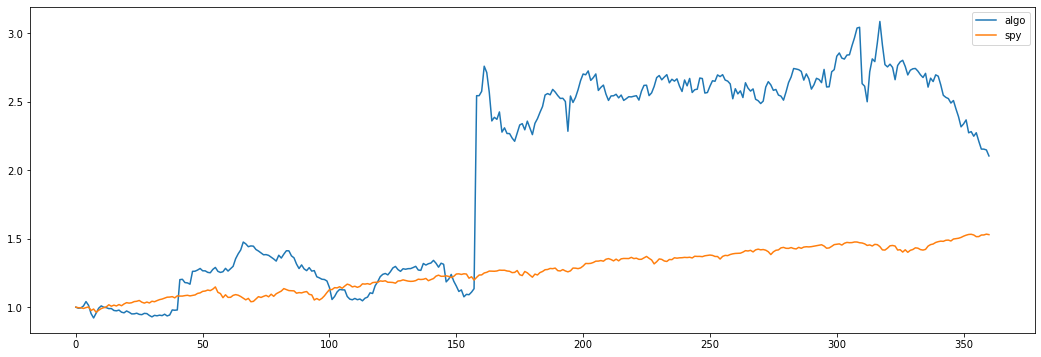

In [8]:
algo_cumret = np.nancumprod(np.array(algo_ret)+1)
market_cumret = cumret_norm['SPY'].values[30:]
market_cumret /= market_cumret[0]

plt.figure(figsize=(18,6))
plt.plot(algo_cumret, label='algo')
plt.plot(market_cumret, label='spy')
plt.legend()

# Strategy 1 approach 2

In [9]:
with open('spread_params.pkl', 'rb') as f:
    good_pairs_all = pickle.load(f)

selected_pairs_long = []
selected_pairs_short = []
algo_ret = []
num_days = len(cumret_norm.index)

for i in range(30,num_days):
    cumret_tmp = cumret_norm.iloc[i-30:i]
    ret_tmp = returns.iloc[i-1]
    
    # calculate returns
    daily_returns_long = []
    daily_returns_short = []
    if len(selected_pairs_long)>0:
        for pair in selected_pairs_long:
            s1,s2 = parse_pair(pair)
            daily_returns_long.append(ret_tmp[s1] - ret_tmp[s2])
            selected_pairs_long = []
    if len(selected_pairs_short)>0:
        for pair in selected_pairs_short:
            s1,s2 = parse_pair(pair)
            daily_returns_short.append(-ret_tmp[s1] + ret_tmp[s2])
            selected_pairs_short = []
    
    # equal capital allocations to longs\shorts
    daily_return_total = np.mean(daily_returns_long) + np.mean(daily_returns_short)
    algo_ret.append(daily_return_total)

                        
    date = returns.index[i-1]
    if len(good_pairs_all[date].index)>0:
        # calculate spreads
        pairs_df = good_pairs_all[date]

        for pair in pairs_df.index:
            s1,s2 = parse_pair(pair)
            params = pairs_df.loc[pair]
            observed_spread = (cumret_tmp[s1] - cumret_tmp[s2]).values
            yesterday_pred, today_est = kalman_filter(observed_spread, params)
            pairs_df.loc[pair, ['spread_est']] = today_est # x_{k|k}
            pairs_df.loc[pair, ['y']] = observed_spread[-1] # y_k

        pairs_df['spread_pred_tom'] = pairs_df['A'] + pairs_df['B'] * pairs_df['spread_est']
        pairs_df['current-predicted_tom'] = pairs_df['y'] - pairs_df['spread_pred_tom']
        
        selected_pairs_long = pairs_df[pairs_df['current-predicted_tom']>0].index
        selected_pairs_short = pairs_df[pairs_df['current-predicted_tom']<0].index

/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


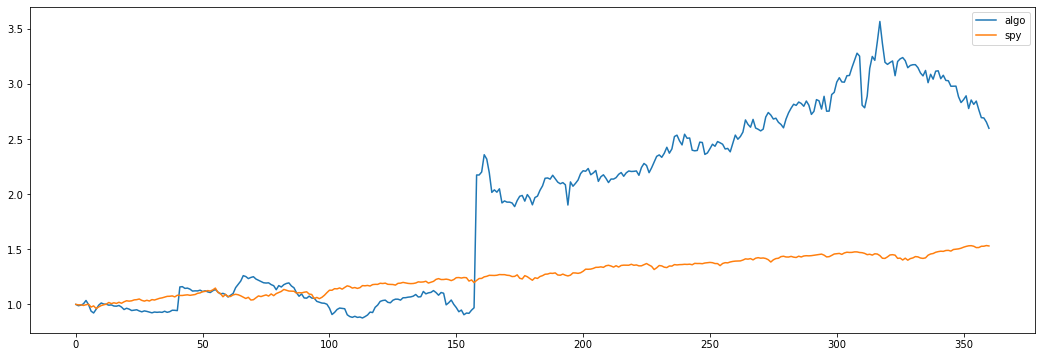

In [10]:
algo_cumret = np.nancumprod(np.array(algo_ret)+1)
market_cumret = cumret_norm['SPY'].values[30:]
market_cumret /= market_cumret[0]

plt.figure(figsize=(18,6))
plt.plot(algo_cumret, label='algo')
plt.plot(market_cumret, label='spy')
plt.legend()

# Strategy 2

In [11]:
with open('spread_params.pkl', 'rb') as f:
    good_pairs_all = pickle.load(f)

selected_pairs_long = []
selected_pairs_short = []
algo_ret = []
num_days = len(cumret_norm.index)

c = 0

for i in range(30,num_days):
    cumret_tmp = cumret_norm.iloc[i-30:i]
    ret_tmp = returns.iloc[i-1]
    
    # calculate returns
    daily_returns_long = []
    daily_returns_short = []
    if len(selected_pairs_long)>0:
        for pair in selected_pairs_long:
            s1,s2 = parse_pair(pair)
            daily_returns_long.append(ret_tmp[s1] - ret_tmp[s2])
            selected_pairs_long = []
    if len(selected_pairs_short)>0:
        for pair in selected_pairs_short:
            s1,s2 = parse_pair(pair)
            daily_returns_short.append(-ret_tmp[s1] + ret_tmp[s2])
            selected_pairs_short = []
    
    # equal capital allocations to longs\shorts
    daily_return_total = np.mean(daily_returns_long) + np.mean(daily_returns_short)
    algo_ret.append(daily_return_total)

                        
    date = returns.index[i-1]
    if len(good_pairs_all[date].index)>0:
        # calculate spreads
        pairs_df = good_pairs_all[date]

        for pair in pairs_df.index:
            s1,s2 = parse_pair(pair)
            params = pairs_df.loc[pair]
            observed_spread = (cumret_tmp[s1] - cumret_tmp[s2]).values
            pairs_df.loc[pair, ['y']] = observed_spread[-1] # y_k
        
        # calculate mu, rho, and sigma
        pairs_df['mu'] = pairs_df['A'] / (1 - pairs_df['B'])
        pairs_df['rho'] = 1 - pairs_df['B']
        pairs_df['sigma'] = pairs_df['C']

        # calculate upper\lower thresholds
        pairs_df['upper'] = pairs_df['mu'] + c * pairs_df['sigma'] / np.sqrt(2 * pairs_df['rho'])
        pairs_df['lower'] = pairs_df['mu'] - c * pairs_df['sigma'] / np.sqrt(2 * pairs_df['rho'])
        
        selected_pairs_long = pairs_df[pairs_df['y'] < pairs_df['lower']].index
        selected_pairs_short = pairs_df[pairs_df['y'] > pairs_df['upper']].index

/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


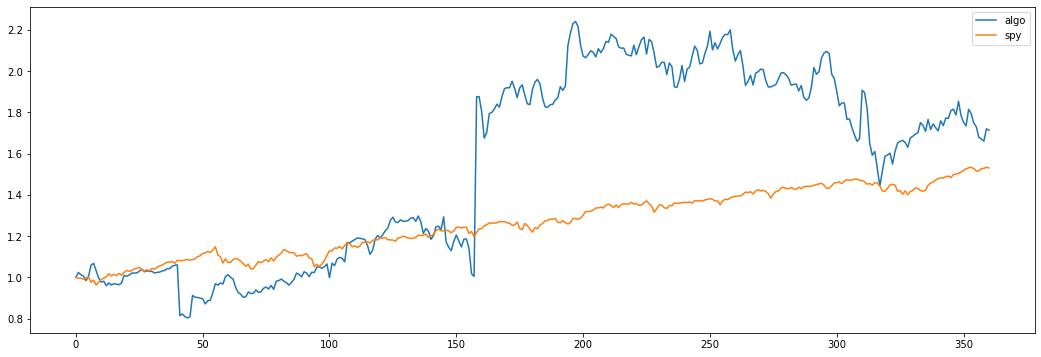

In [12]:
algo_cumret = np.nancumprod(np.array(algo_ret)+1)
market_cumret = cumret_norm['SPY'].values[30:]
market_cumret /= market_cumret[0]

plt.figure(figsize=(18,6))
plt.plot(algo_cumret, label='algo')
plt.plot(market_cumret, label='spy')
plt.legend()